# Analysis and plots.



In [37]:
import os
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 15, 9
plt.rcParams['font.size'] = 19
plt.rcParams['axes.titlesize'] = 24

In [38]:
# Needs MafSSO branch from sims_maf.
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as mmb

In [41]:
# Read PHA and NEO observations (MBAs coming)
runName = 'enigma_1189'
# Go through all types of objects, with 2k results. 
moslicers = {}
objtypes = ['neos', 'mbas']
Hrange = np.arange(15, 27, 0.25)
for obj in objtypes:
    orbitfile = os.path.join('test_2k', obj+'_2k.des')
    moslicers[obj] = slicers.MoSlicer(orbitfile, Hrange=Hrange)
    obsfile = os.path.join('test_2k', runName + '_' + obj + '_2k', obj+'_2k_allObs.txt' )
    moslicers[obj].readObs(obsfile)

In [42]:
# Set up metrics and metric bundles.
allBundles = {}
nyears = [2, 4, 6, 8, 10]
psfFactor = 2.0
windows = np.arange(1, 40, 3)*5
bins = np.arange(5, 95, 10.)
summaryMetrics = [metrics.MO_CompletenessMetric(), metrics.MO_CumulativeCompletenessMetric()]
for obj in objtypes:
    bundles = {}
    slicer = moslicers[obj]
    plotDict = {}
    constraint = None
    metadata = obj
    
    
    metric = metrics.NObsMetric()
    bundles['NObs'] = mmb.MoMetricBundle(metric, slicer, constraint, 
                                         runName=runName, metadata=metadata, 
                                         plotDict=plotDict)
    metric = metrics.ObsArcMetric()
    bundles['Arclength'] = mmb.MoMetricBundle(metric, slicer, constraint,
                                              runName=runName, metadata=metadata, 
                                              plotDict=plotDict)
    bundles['ActivityTime'] = {}
    for w in windows:
        metric = metrics.ActivityOverTimeMetric(w, metricName='Chances of Detecting Activity lasting %.0f days' %(w))
        bundles['ActivityTime'][w] = mmb.MoMetricBundle(metric, slicer, constraint, 
                                                       runName=runName, metadata=metadata, plotDict=plotDict)
    bundles['ActivityPeriod'] = {}
    for b in bins:
        metric = metrics.ActivityOverPeriodMetric(b, metricName=
                                                'Chances of Detecting Activity lasting %.0f of the period' %(b/360.0))
        bundles['ActivityPeriod'][b] = mmb.MoMetricBundle(metric, slicer, constraint,
                                                        runName=runName, metadata=metadata, plotDict=plotDict)
    
    metric = metrics.HighVelocityNightsMetric(psfFactor=psfFactor, nObsPerNight=2)
    bundles['Velocity'] = mmb.MoMetricBundle(metric, slicer, constraint,
                                            runName=runName, metadata=metadata,
                                            plotDict=plotDict, summaryMetrics=summaryMetrics)
    metric = metrics.MagicDiscoveryMetric(nObs=6, tWindow=60)
    md = metadata + ' 6 obs in 60 nights'
    bundles['Magic'] = mmb.MoMetricBundle(metric, slicer, constraint,
                                         runName=runName, metadata=md, 
                                         plotDict=plotDict, summaryMetrics=summaryMetrics)
    
    bundles['discovery'] = {}
    bundles['extrapair'] = {}
    bundles['longdisc'] = {}
    for yr in nyears:
        metric = metrics.DiscoveryChancesMetric(tNight=90./60./24., nObsPerNight=2, 
                                            nNightsPerWindow=3, tWindow=15)
        constraint = 'night < %d' %(yr * 365 + 1)
        md = metadata + ' year %d, 3 pairs in 15 nights' %(yr)
        bundles['discovery'][yr] = mmb.MoMetricBundle(metric, slicer, constraint, 
                                            runName=runName, metadata=md, 
                                            plotDict=plotDict, summaryMetrics=summaryMetrics)
        # 'extra pair' discovery conditions - 4 pairs in 20 nights.
        metric = metrics.DiscoveryChancesMetric(tNight=90./60./24., nObsPerNight=2, 
                                          nNightsPerWindow=4, tWindow=20)
        md = metadata + ' year %d, 4 pairs in 20 nights' %(yr)
        bundles['extrapair'][yr] = mmb.MoMetricBundle(metric, slicer, constraint, 
                                                 runName=runName, metadata=md, 
                                                 plotDict=plotDict, summaryMetrics=summaryMetrics)
        # 'long' discovery window - 3 pairs in 30 nights.
        metric = metrics.DiscoveryChancesMetric(tNight=90./60./24., nObsPerNight=2,
                                          nNightsPerWindow=3, tWindow=30)
        md = metadata + ' year %d, 3 pairs in 30 nights' %(yr)
        bundles['longdisc'][yr] = mmb.MoMetricBundle(metric, slicer, constraint, 
                                                 runName=runName, metadata=md, 
                                                 plotDict=plotDict, summaryMetrics=summaryMetrics)
    allBundles[obj] = bundles

In [43]:
# combine all metric bundles in the dict into one flat dict
bdict = {}
for obj in allBundles:
    bdict[obj] = {}
    count = 0
    for k, v in allBundles[obj].iteritems():
        if isinstance(v, dict):
            for k2, v2 in v.iteritems():
                bdict[obj][count] = v2
                count += 1
        else:
            bdict[obj][count] = v
            count += 1
    print obj, count

neos 41
mbas 41


In [44]:
# Run all the metricbundles. This will take a while - we're computing lots of things. 
outDir = 'testout'
for obj in bdict:
    print "Calculating for ", obj
    bg = mmb.MoMetricBundleGroup(bdict[obj], outDir=outDir)
    bg.runAll()
    bg.summaryAll()

Calculating for  neos
Calculated all metrics.
Calculating for  mbas
Calculated all metrics.


In [51]:
plotdicts = {}
plotdicts['mbas'] = {'color':'r', 'label':'MBAs'}
plotdicts['neos'] = {'color':'g', 'label':'NEOs'}
plotdicts['phas'] = {'color':'b', 'label':'PHAs'}
plotdicts['mpcphas'] = {'color':'m', 'label':'MPC PHAs'}
albedo = 0.07
yearColors = {2:'k', 4:'b', 6:'g', 8:'y', 10:'r', 12:'m', 15:'k'}

In [52]:
ph = plots.PlotHandler(outDir=outDir, savefig=True)

In [53]:
# Will use a mock metricBundle to generate plots. 
# The completeness values (what we typically want to plot here) are a summary value, not an actual metric value.
# So this little bit of fiddling lets us use the plotHandler as we would normally (with a metricBundle), but with 
# the actual values we want to plot. 
def makeCompletenessBundle(slicer, completenessValues, plotDict):
    completeness = ma.MaskedArray(data=completenessValues, mask=np.zeros(len(completenessValues)), fill_value=0)
    mb = mmb.MoMetricBundle(metrics.MO_CumulativeCompletenessMetric(), slicer, constraint=None,
                            runName=runName, plotDict=plotDict)
    mb.metricValues = completeness
    return mb

1

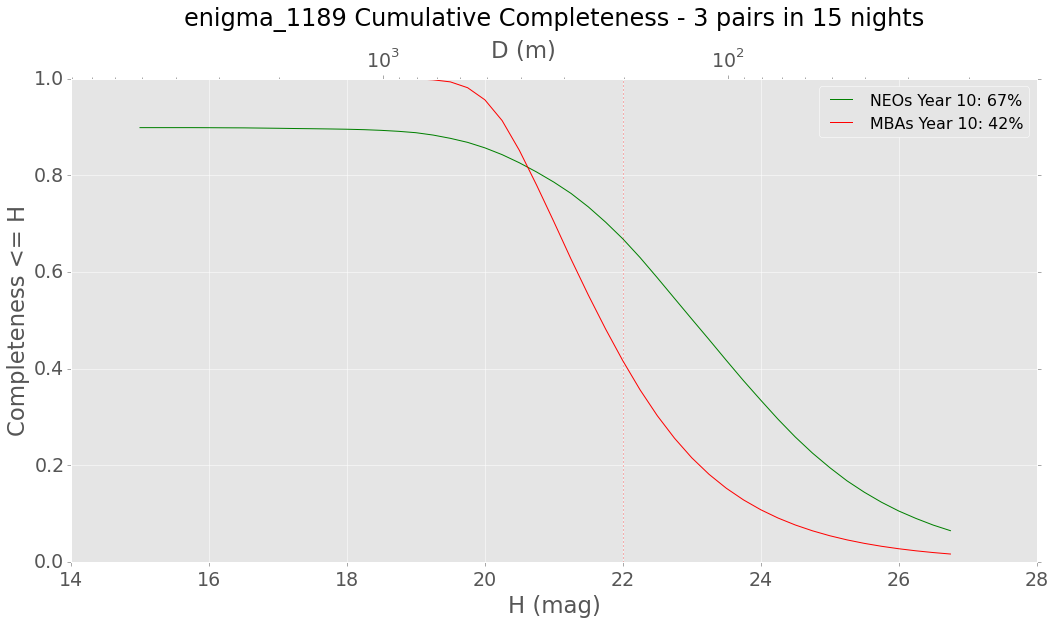

In [54]:
# Will use a mock metricBundle to generate plots. 
# The completeness values (what we typically want to plot here) are a summary value, not an actual metric value.
# So this little bit of fiddling lets us use the plotHandler as we would normally (with a metricBundle), but with 
# the actual values we want to plot. 

# Cumulative completeness, as function of H (for each of nyear above)
compbundles = []
yr = max(nyears)
Hmark = 22

for obj in objtypes:
    mos = moslicers[obj]
    Hidx = np.where(mos.Hrange == Hmark)[0]

    completeness = allBundles[obj]['discovery'][yr].summaryValues['CumulativeCompleteness'][0]
    cval = completeness[Hidx]
    #print obj, Hidx, cval, completeness, mos.Hrange
    plotDict = {'albedo':albedo, 'label':'%s Year %d: %.0f%s' %(plotdicts[obj]['label'], yr, cval*100, '%'), 
                'color':plotdicts[obj]['color'], 
                'title':'%s Cumulative Completeness - 3 pairs in 15 nights' %(runName), 
                'ylabel':'Completeness <= H', 'yMin':0, 'yMax':1, 'Hmark':22}
    mb = makeCompletenessBundle(mos, completeness, plotDict)
    compbundles.append(mb)
ph.setMetricBundles(compbundles)
ph.plot(plotFunc=plots.MetricVsH())

KeyError: 10

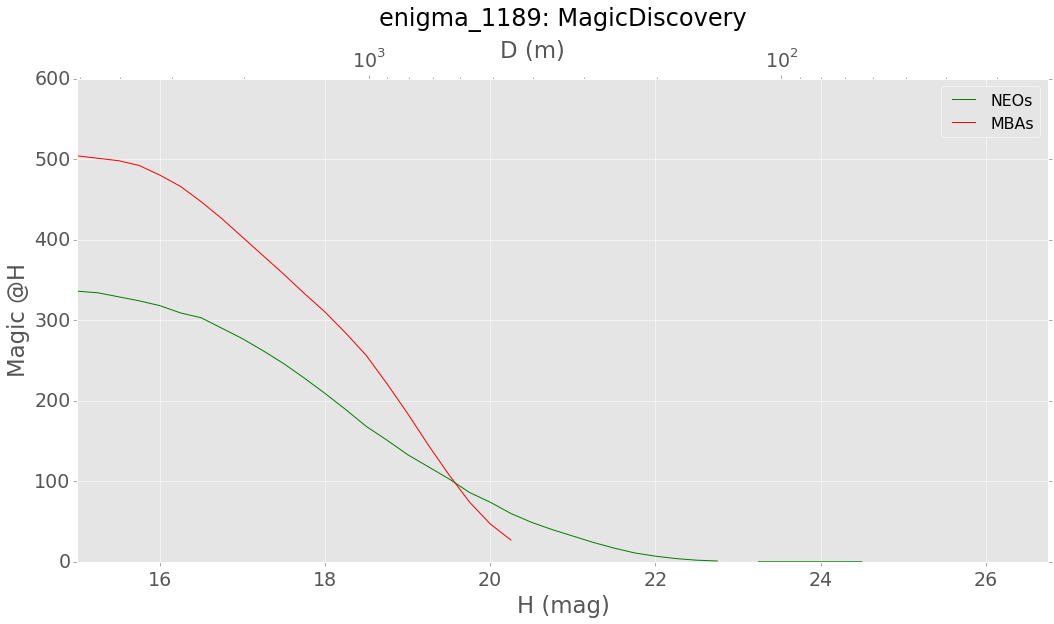

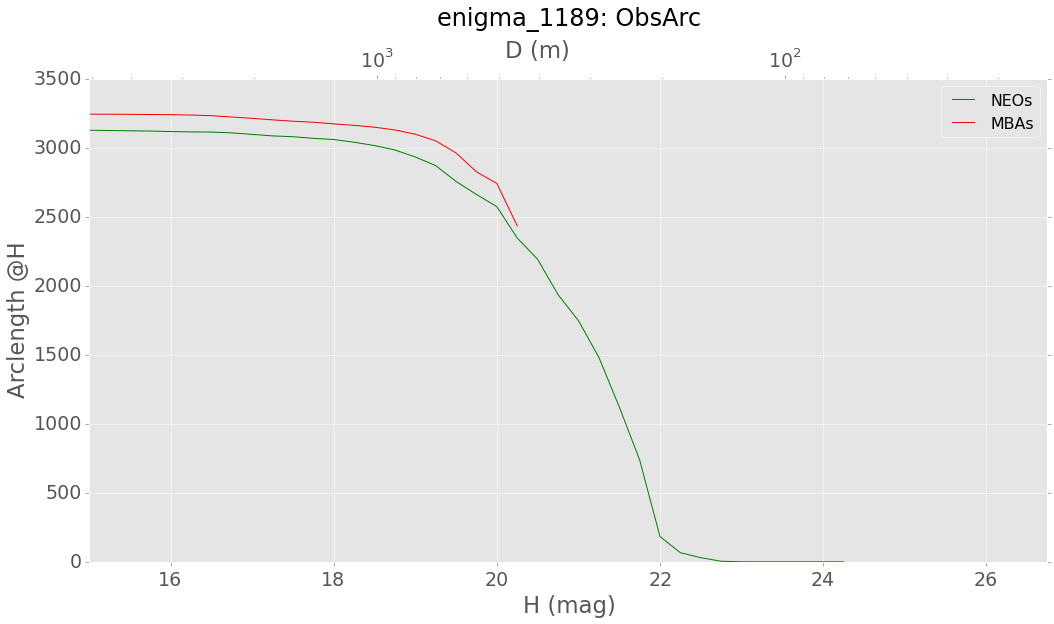

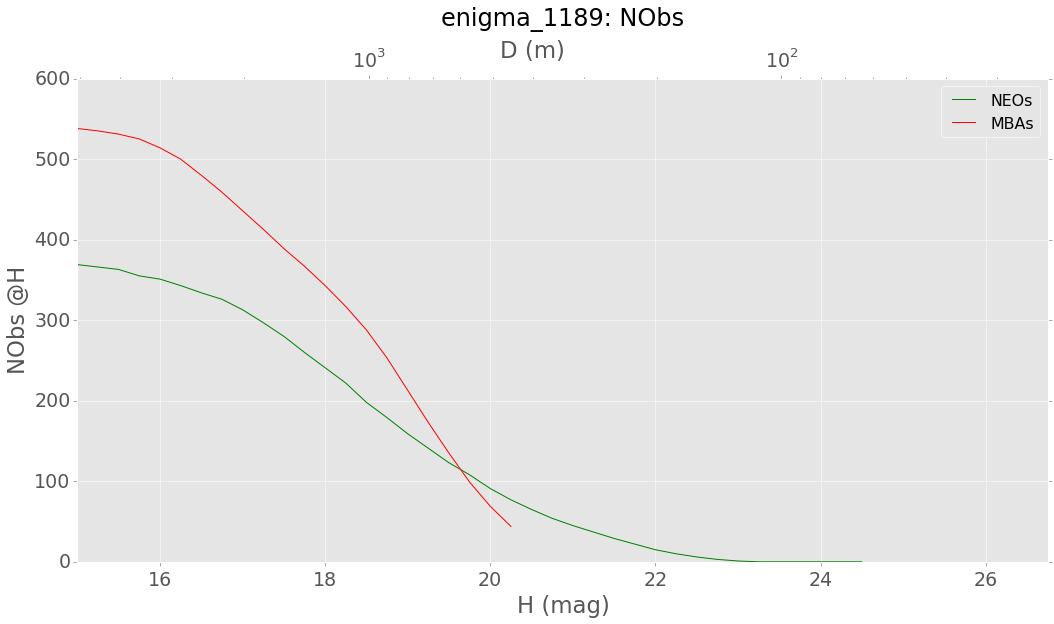

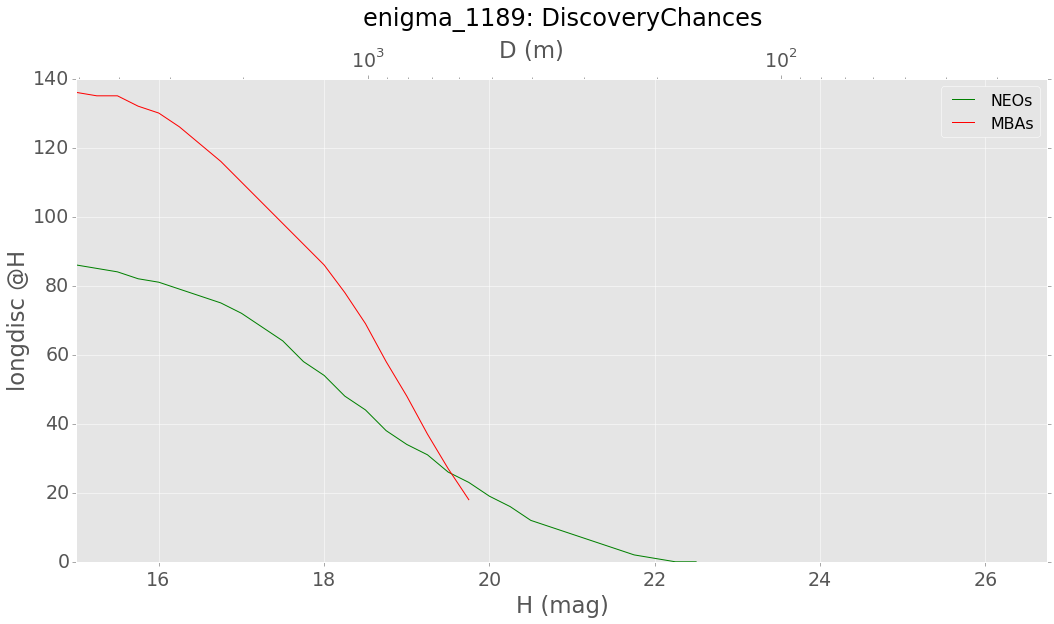

In [56]:
# PLOT the MEDIAN values of each of these metrics as function of H.
for mplot in allBundles['neos'].keys():
    plotFunc = plots.MetricVsH()
    bundles = []
    pds = []
    for obj in objtypes:
        b = allBundles[obj][mplot]
        if isinstance(b, dict):
            b = allBundles[obj][mplot][yr]
        bundles.append(b)
        pds.append(plotdicts[obj])
    ph.setMetricBundles(bundles)
    ph.setPlotDicts(pds)
    ylabel = '%s %s' %(mplot, bundles[0].plotDict['units'])
    ph.plot(plotFunc=plotFunc, plotDicts={'npReduce':np.median, 'ylabel':ylabel, 'albedo':albedo,
                                         'xMin':Hrange[0], 'xMax':Hrange[-1]})

(3, 27)

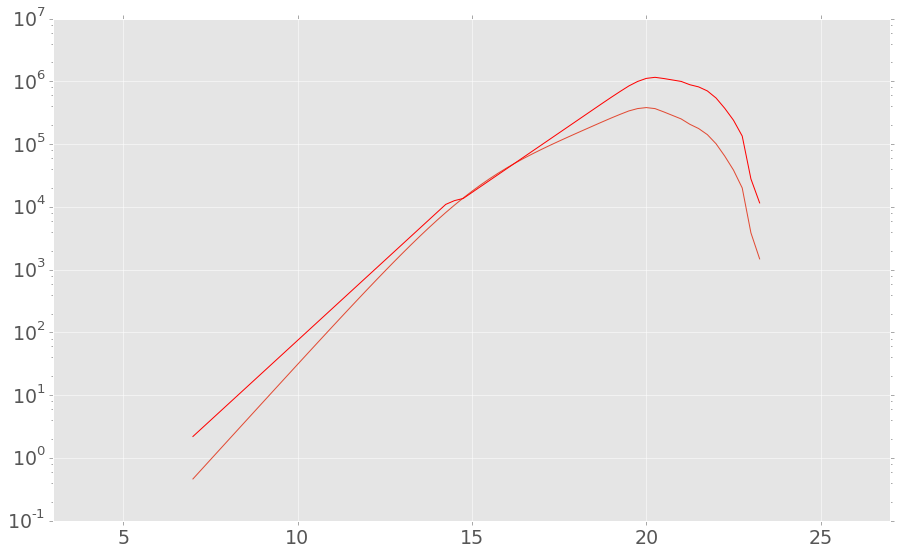

In [58]:
# Turn completeness into number of objects for MBAs
obj = 'mbas'
mos = moslicers[obj]
Hrange = mos.Hrange
Hbinsize = np.unique(np.diff(Hrange))[0]
Hextension = np.arange(7, Hrange.min()-Hbinsize/2.0, Hbinsize)
bigHrange = np.concatenate([Hextension, Hrange])

yr=max(nyears)
completeness = allBundles[obj]['discovery'][yr].summaryValues['Completeness'][0]
bigcompleteness = np.concatenate([np.ones(len(Hextension)), completeness])

diffHrange = np.concatenate([(bigHrange - Hbinsize/2.0), np.array([Hrange.max() + Hbinsize/2.0])])
x = diffHrange - 15.7
ncum = 267000 * (np.power(10, 0.43*x))/(np.power(10, 0.18*x) + np.power(10, -0.18*x))
ndiff = ncum[1:] - ncum[:-1]
nfound = ndiff * bigcompleteness

ncum2 = np.zeros(len(diffHrange))
C = np.log10(50000) # @ H=14.5
condition = np.where(diffHrange>14.5)
ncum2[condition] = np.power(10, C + 0.38 * (diffHrange[condition] - 14.5) )
condition = np.where(diffHrange<=14.5)
ncum2[condition] = np.power(10, C + 0.51 * (diffHrange[condition] - 14.5))
ndiff2 = ncum2[1:] - ncum2[:-1]
nfound2 = ndiff2 * bigcompleteness
#for H, N, Nf in zip(Hrange, ncum, nfound):
#    print H, N, Nf
fig = plt.figure()
plt.semilogy(bigHrange, nfound)
plt.semilogy(bigHrange, nfound2, 'r-')
ax = fig.gca()
plt.xlim(3, 27)

(3, 27)

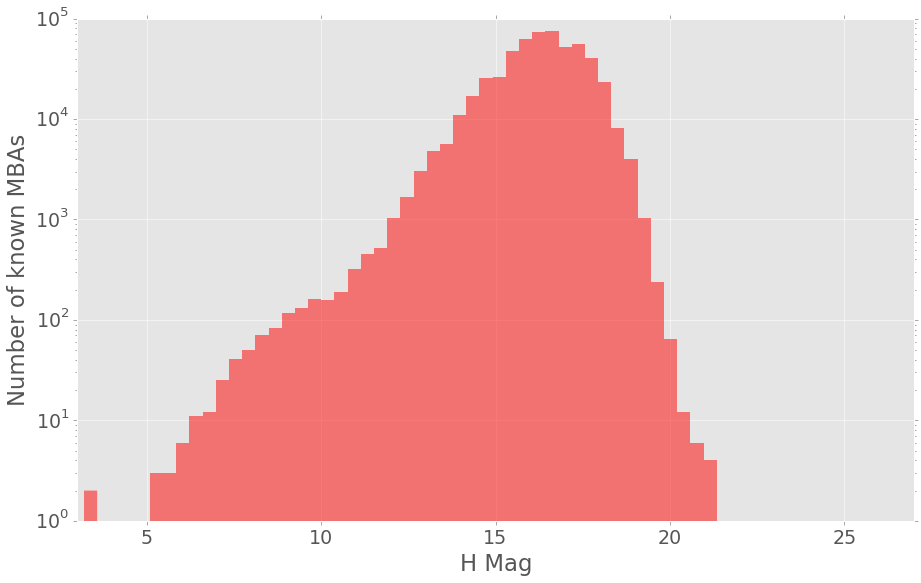

In [59]:
import pandas as pd
ast = pd.read_table('asteroidDb/mpc_mba.dat', delim_whitespace=True, error_bad_lines=False)
ast['H'].plot(kind='hist', bins=50, logy=True, alpha=0.5, color='r', edgecolor='none', label='Known MBAs')
plt.xlabel('H Mag')
plt.ylabel('Number of known MBAs')
plt.xlim(3, 27)

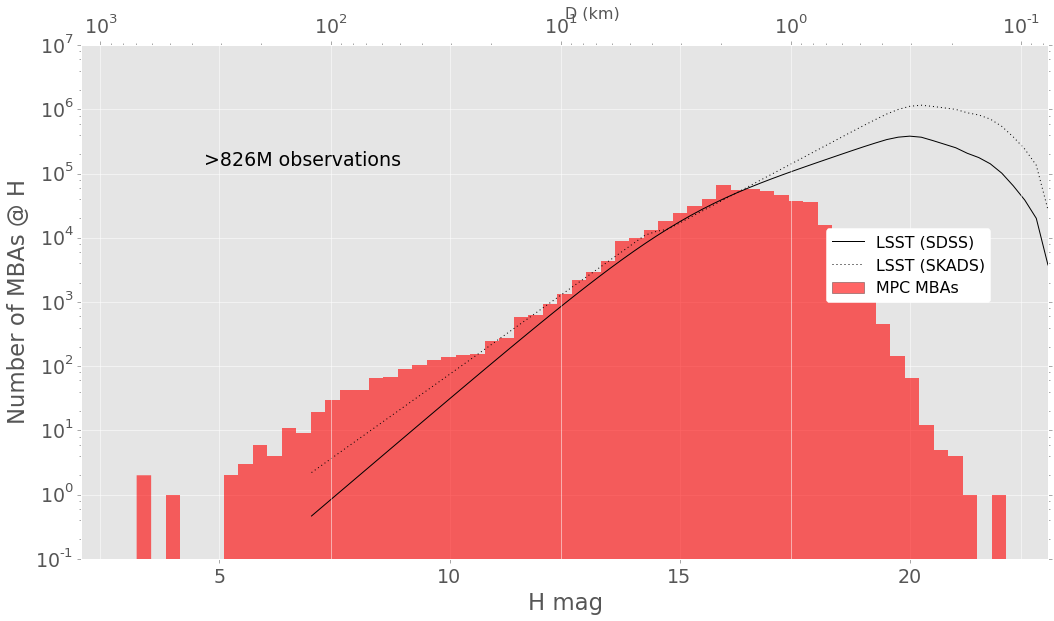

In [70]:
# Differential count of number of MBAs
plt.plot(bigHrange[:-9], nfound[:-9],  color='k', label='LSST (SDSS)')
plt.plot(bigHrange[:-9], nfound2[:-9], color='k', linestyle=':', label='LSST (SKADS)')
plt.hist(ast['H'], bins=60, alpha=0.6, color='r', edgecolor='none', label='MPC MBAs')
leg = plt.legend(loc=(0.77, 0.5), fancybox=True, numpoints=1, fontsize='smaller')
leg.get_frame().set_zorder(0)
leg.get_frame().set_facecolor('white')
plt.ylabel("Number of MBAs @ H")
plt.xlabel("H mag")
plt.xlim(2, 23.)

mag_sun = -27.1 
km_per_au = 1.496e8
albedo = 0.14
ax = plt.axes()
ax2 = ax.twiny()
hmin, hmax = ax.get_xlim()
dmax = 2.0 * np.sqrt(10**((mag_sun - hmin - 2.5*np.log10(albedo))/2.5))
dmin = 2.0 * np.sqrt(10**((mag_sun - hmax - 2.5*np.log10(albedo))/2.5))
dmax = dmax * km_per_au
dmin = dmin * km_per_au
ax2.set_xlim(dmax, dmin)
ax2.set_xscale('log')
ax2.set_xlabel('D (km)', labelpad=-5, horizontalalignment='left', fontsize='smaller')
plt.sca(ax)
plt.grid(True)
plt.yscale('log', nonposy='clip')
plt.figtext(0.2, 0.72, '>826M observations')
plt.tight_layout()
plt.savefig(os.path.join(outDir, 'N_MBAs.png'), dpi=600)

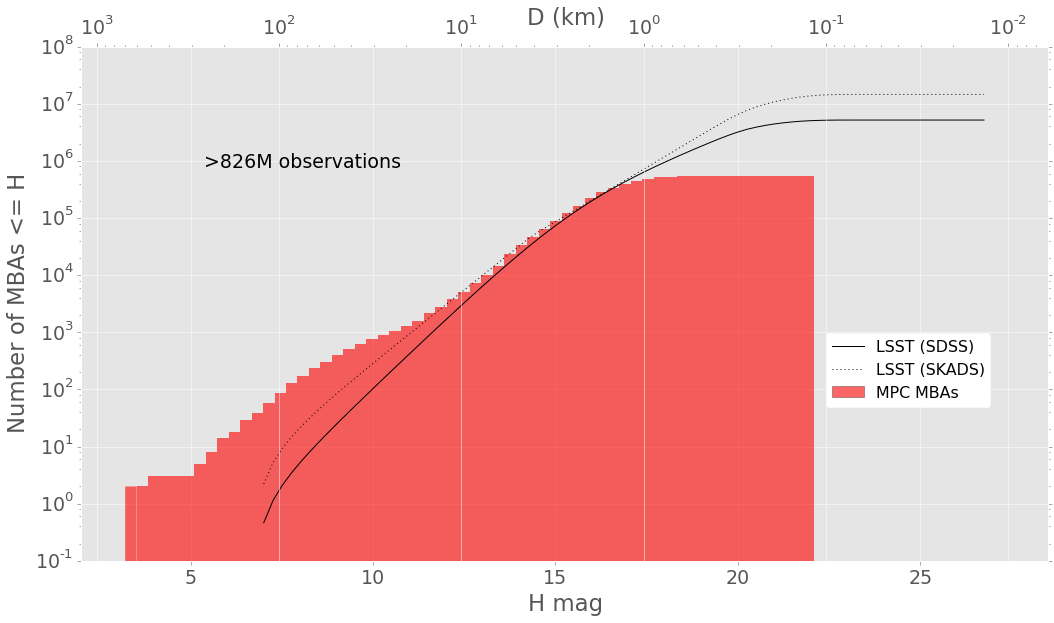

In [71]:
# cumulative number of objects (<=H)
plt.plot(bigHrange, nfound.cumsum(),  color='k', label='LSST (SDSS)')
plt.plot(bigHrange, nfound2.cumsum(), color='k', linestyle=':', label='LSST (SKADS)')
plt.hist(ast['H'], bins=60, alpha=0.6, color='r', edgecolor='none', label='MPC MBAs', cumulative=True)
leg = plt.legend(loc=(0.77, 0.3), fancybox=True, numpoints=1, fontsize='smaller')
leg.get_frame().set_zorder(0)
leg.get_frame().set_facecolor('white')
plt.ylabel("Number of MBAs <= H")
plt.xlabel("H mag")
plt.xlim(2, 28.5)

mag_sun = -27.1 
km_per_au = 1.496e8
albedo = 0.14
ax = plt.axes()
ax2 = ax.twiny()
hmin, hmax = ax.get_xlim()
dmax = 2.0 * np.sqrt(10**((mag_sun - hmin - 2.5*np.log10(albedo))/2.5))
dmin = 2.0 * np.sqrt(10**((mag_sun - hmax - 2.5*np.log10(albedo))/2.5))
dmax = dmax * km_per_au
dmin = dmin * km_per_au
ax2.set_xlim(dmax, dmin)
ax2.set_xscale('log')
ax2.set_xlabel('D (km)', labelpad=-10, horizontalalignment='center')
plt.sca(ax)
plt.grid(True)
plt.yscale('log', nonposy='clip')
plt.figtext(0.2, 0.72, '>826M observations')
plt.tight_layout()
plt.savefig(os.path.join(outDir, 'N_MBAs_cum.png'), dpi=600)